In [1]:
import pandas as pd
import numpy as np
import datetime as dt

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from fext import esios

In [3]:
import config

sns.set(
    rc=config.set_plot_features(), style="darkgrid"
       )

TOKEN = config.ESIOS_API_KEY
PATH = "./data/"

In [4]:
START_DATE="2014-01-01"
END_DATE = dt.datetime.now().date().strftime("%Y-%m-%d")

start_date_suffix = START_DATE.replace("-","_")
end_date_suffix = END_DATE.replace("-","_")

### Test ESIOS API to retrieve indicators metadata

In [8]:
import requests
import json

url = "https://api.esios.ree.es/indicators/"

headers = {'content-Type': 'application/json', 'Authorization': 'Token token={}'.format(TOKEN)}

response = requests.get(url, headers=headers, stream=True)
print(response)

<Response [200]>


In [9]:
data_dict0 = json.loads(response.content.decode('UTF-8'))
data_dict0

{'indicators': [{'name': 'Precio de la energía excedentaria del autoconsumo para el mecanismo de compensación simplificada (PVPC)',
   'description': '<p>Precio horario de la energ&iacute;a excedentaria vertida a la red por las instalaciones de generaci&oacute;n de los consumidores que dispongan de un contrato de suministro al PVPC (Precio Voluntario para el Peque&ntilde;o Consumidor) con una comercializadora de referencia, y est&eacute;n acogidos al mecanismo de compensaci&oacute;n simplificada definido en el art&iacute;culo 14 del Real Decreto 244/2019, de 5 de abril.</p>\r\n\r\n<p>La energ&iacute;a horaria excedentaria se valora al precio medio horario, Pmh (definido en el art&iacute;culo 10, Real Decreto 216/2014, de 28 de marzo) obtenido a partir de los resultados del mercado diario e intradiario en la hora h, menos el coste de los desv&iacute;os CDSVh (definido en el art&iacute;culo 11, Real Decreto 216/2014, de 28 de marzo). No incluye impuestos.</p>\r\n\r\n<p>La energ&iacute;a 

In [10]:
indicators_df = pd.DataFrame(data_dict0['indicators'])
indicators_df.head()

,description,id,name
0,<p>Precio horario de la energ&iacute;a exceden...,1739,Precio de la energía excedentaria del autocons...
1,<p>La regulación secundaria es un servicio com...,899,Coste asignación de banda de Regulación Secund...
2,<p>Precio de referencia del Mercado Intradiari...,1727,Precio de referencia en Mercado Intradiario Co...
3,<p>El proceso de solución de restricciones téc...,1723,Coste del proceso de solución de Restricciones...
4,<p>El proceso de solución de restricciones téc...,10341,Precio medio ponderado de solución de Restricc...


In [11]:
indicators_df[["id","name","description"]].to_excel("esios_indicators.xlsx", index=False)

### Query ESIOS API to retrieve aggregated data from one indicator

**Download daily average SPOT price**

In [12]:
_, data_dict, data_df = esios.get_esios_data(token=TOKEN,
                                       indicator = 600,
                    start_dt= '2019-05-31',
                    end_dt= '2019-06-03',
                    period = 'day',
                    agg= "average",
                    dev=False
                                      )


Response regarindg indicator: 600 status: 200


In [13]:
data_df

,datetime,datetime_utc,geo_id,geo_name,tz_time,value,indicador,idx
0,2019-05-31T00:00:00.000+02:00,2019-05-30T22:00:00Z,1,Portugal,2019-05-30T22:00:00.000Z,55.321667,Precio mercado SPOT Diario,600
1,2019-05-31T00:00:00.000+02:00,2019-05-30T22:00:00Z,2,Francia,2019-05-30T22:00:00.000Z,33.818750,Precio mercado SPOT Diario,600
2,2019-05-31T00:00:00.000+02:00,2019-05-30T22:00:00Z,3,España,2019-05-30T22:00:00.000Z,55.321667,Precio mercado SPOT Diario,600
3,2019-06-01T00:00:00.000+02:00,2019-05-31T22:00:00Z,1,Portugal,2019-05-31T22:00:00.000Z,53.284583,Precio mercado SPOT Diario,600
4,2019-06-01T00:00:00.000+02:00,2019-05-31T22:00:00Z,3,España,2019-05-31T22:00:00.000Z,53.284583,Precio mercado SPOT Diario,600
5,2019-06-01T00:00:00.000+02:00,2019-05-31T22:00:00Z,2,Francia,2019-05-31T22:00:00.000Z,28.877083,Precio mercado SPOT Diario,600
6,2019-06-02T00:00:00.000+02:00,2019-06-01T22:00:00Z,3,España,2019-06-01T22:00:00.000Z,47.817500,Precio mercado SPOT Diario,600
7,2019-06-02T00:00:00.000+02:00,2019-06-01T22:00:00Z,2,Francia,2019-06-01T22:00:00.000Z,17.690833,Precio mercado SPOT Diario,600
8,2019-06-02T00:00:00.000+02:00,2019-06-01T22:00:00Z,1,Portugal,2019-06-01T22:00:00.000Z,47.817500,Precio mercado SPOT Diario,600
9,2019-06-03T00:00:00.000+02:00,2019-06-02T22:00:00Z,1,Portugal,2019-06-02T22:00:00.000Z,53.415000,Precio mercado SPOT Diario,600


### Query ESIOS API to retrieve aggregated data from multiple indicators

**Basic example**

In [14]:
multi_data_dict, multi_data_df = esios.get_esios_multi_data(TOKEN, period='day')

Response regarindg indicator: 10258 status: 200
Response regarindg indicator: 1293 status: 200


In [15]:
multi_data_df

,datetime,datetime_utc,geo_id,geo_name,tz_time,value,indicador,idx
0,2018-06-01T00:00:00.000+02:00,2018-05-31T22:00:00Z,8741,Península,2018-05-31T22:00:00.000Z,581615.7,Generación programada PBF total,10258
1,2018-06-02T00:00:00.000+02:00,2018-06-01T22:00:00Z,8741,Península,2018-06-01T22:00:00.000Z,514472.0,Generación programada PBF total,10258
0,2018-06-01T00:00:00.000+02:00,2018-05-31T22:00:00Z,8741,Península,2018-05-31T22:00:00.000Z,4006140.0,Demanda real,1293
1,2018-06-02T00:00:00.000+02:00,2018-06-01T22:00:00Z,8741,Península,2018-06-01T22:00:00.000Z,3594793.0,Demanda real,1293


### Download and build a dataset with market pool price and generation share by technology

**Get indicators list and split it by aggregating function**

In [16]:
tickers_df = pd.read_excel('esios_ind_retrieve_list.xlsx')
tickers_df

,id,variable,Unidad de medida
0,600,Precio mercado spot diario,MWh
1,10238,Generación programada P48 Exportación Total,MWh
2,10237,Generación programada P48 Importación Total,MWh
3,10011,Generación programada P48 Cogeneración,MWh
4,10010,Generación programada P48 Eólica,MWh
5,10008,Generación programada P48 Carbón,MWh
6,95,Generación programada P48 Consumo bombeo,MWh
7,87,Generación programada P48 Gas Natural Cogenera...,MWh
8,91,Generación programada P48 Biomasa,MWh
9,85,Generación programada P48 Solar térmica,MWh


In [17]:
indicators_retr_sum = list(tickers_df["id"].unique())[1:-3]

indicators_retr_sum

[10238,
 10237,
 10011,
 10010,
 10008,
 95,
 87,
 91,
 85,
 84,
 79,
 73,
 74,
 72,
 71,
 10063,
 10258]

In [18]:
indicators_retr_avg = list(tickers_df["id"].unique())[0]
indicators_retr_avg

600

**Download and index price data**

In [19]:
data_price_14_19_dict, data_price_14_19_df = esios.get_esios_multi_data(token=TOKEN,
                    indicators = [600],
                    start_dt = START_DATE,
                    end_dt = END_DATE,
                    period = 'day',
                    agg = 'average',
                    dev=False
                  )

Response regarindg indicator: 600 status: 200


In [20]:
data_price_14_19_df["date"] = pd.to_datetime(data_price_14_19_df["datetime"].str[:10],infer_datetime_format=True).dt.date
data_price_14_19_df.index= data_price_14_19_df["date"]
data_price_14_19_df.head()

,datetime,datetime_utc,geo_id,geo_name,tz_time,value,indicador,idx,date
date,,,,,,,,,
2014-01-01,2014-01-01T00:00:00.000+01:00,2013-12-31T23:00:00Z,1,Portugal,2013-12-31T23:00:00.000Z,5.80875,Precio mercado SPOT Diario,600,2014-01-01
2014-01-01,2014-01-01T00:00:00.000+01:00,2013-12-31T23:00:00Z,2,Francia,2013-12-31T23:00:00.000Z,12.92625,Precio mercado SPOT Diario,600,2014-01-01
2014-01-01,2014-01-01T00:00:00.000+01:00,2013-12-31T23:00:00Z,3,España,2013-12-31T23:00:00.000Z,5.80875,Precio mercado SPOT Diario,600,2014-01-01
2014-01-02,2014-01-02T00:00:00.000+01:00,2014-01-01T23:00:00Z,1,Portugal,2014-01-01T23:00:00.000Z,25.04375,Precio mercado SPOT Diario,600,2014-01-02
2014-01-02,2014-01-02T00:00:00.000+01:00,2014-01-01T23:00:00Z,2,Francia,2014-01-01T23:00:00.000Z,28.71125,Precio mercado SPOT Diario,600,2014-01-02


In [21]:
data_price_14_19_df.tail()

,datetime,datetime_utc,geo_id,geo_name,tz_time,value,indicador,idx,date
date,,,,,,,,,
2019-06-03,2019-06-03T00:00:00.000+02:00,2019-06-02T22:00:00Z,2,Francia,2019-06-02T22:00:00.000Z,35.220000,Precio mercado SPOT Diario,600,2019-06-03
2019-06-03,2019-06-03T00:00:00.000+02:00,2019-06-02T22:00:00Z,3,España,2019-06-02T22:00:00.000Z,53.415000,Precio mercado SPOT Diario,600,2019-06-03
2019-06-04,2019-06-04T00:00:00.000+02:00,2019-06-03T22:00:00Z,1,Portugal,2019-06-03T22:00:00.000Z,49.411250,Precio mercado SPOT Diario,600,2019-06-04
2019-06-04,2019-06-04T00:00:00.000+02:00,2019-06-03T22:00:00Z,2,Francia,2019-06-03T22:00:00.000Z,35.596667,Precio mercado SPOT Diario,600,2019-06-04
2019-06-04,2019-06-04T00:00:00.000+02:00,2019-06-03T22:00:00Z,3,España,2019-06-03T22:00:00.000Z,49.411250,Precio mercado SPOT Diario,600,2019-06-04


**Download and index P48 generation data**

In [23]:
data_gen_14_19_dict, data_gen_14_19_df = esios.get_esios_multi_data(token=TOKEN,
                    indicators = indicators_retr_sum,
                    start_dt = START_DATE,
                    end_dt = END_DATE,
                    period = 'day',
                    agg = 'sum',
                    dev=False
                  )

Response regarindg indicator: 71 status: 200
Response regarindg indicator: 72 status: 200
Response regarindg indicator: 73 status: 200
Response regarindg indicator: 91 status: 200
Response regarindg indicator: 74 status: 200
Response regarindg indicator: 79 status: 200
Response regarindg indicator: 10063 status: 200
Response regarindg indicator: 10258 status: 200
Response regarindg indicator: 84 status: 200
Response regarindg indicator: 85 status: 200
Response regarindg indicator: 87 status: 200
Response regarindg indicator: 10008 status: 200
Response regarindg indicator: 10010 status: 200
Response regarindg indicator: 10011 status: 200
Response regarindg indicator: 10237 status: 200
Response regarindg indicator: 10238 status: 200
Response regarindg indicator: 95 status: 200


In [24]:
data_gen_14_19_df["date"] = pd.to_datetime(data_gen_14_19_df["datetime"].str[:10],infer_datetime_format=True).dt.date
data_gen_14_19_df.index = data_gen_14_19_df["date"]
data_gen_14_19_df.head()

,datetime,datetime_utc,geo_id,geo_name,tz_time,value,indicador,idx,date
date,,,,,,,,,
2014-01-01,2014-01-01T00:00:00.000+01:00,2013-12-31T23:00:00Z,8741,Península,2013-12-31T23:00:00.000Z,54128.3,Generación programada P48 Hidráulica UGH,71,2014-01-01
2014-01-02,2014-01-02T00:00:00.000+01:00,2014-01-01T23:00:00Z,8741,Península,2014-01-01T23:00:00.000Z,69150.3,Generación programada P48 Hidráulica UGH,71,2014-01-02
2014-01-03,2014-01-03T00:00:00.000+01:00,2014-01-02T23:00:00Z,8741,Península,2014-01-02T23:00:00.000Z,76930.1,Generación programada P48 Hidráulica UGH,71,2014-01-03
2014-01-04,2014-01-04T00:00:00.000+01:00,2014-01-03T23:00:00Z,8741,Península,2014-01-03T23:00:00.000Z,83123.3,Generación programada P48 Hidráulica UGH,71,2014-01-04
2014-01-05,2014-01-05T00:00:00.000+01:00,2014-01-04T23:00:00Z,8741,Península,2014-01-04T23:00:00.000Z,96505.4,Generación programada P48 Hidráulica UGH,71,2014-01-05


In [25]:
data_gen_14_19_df.tail()

,datetime,datetime_utc,geo_id,geo_name,tz_time,value,indicador,idx,date
date,,,,,,,,,
2019-05-31,2019-05-31T00:00:00.000+02:00,2019-05-30T22:00:00Z,8741,Península,2019-05-30T22:00:00.000Z,-592.0,Generación programada P48 Consumo bombeo,95,2019-05-31
2019-06-01,2019-06-01T00:00:00.000+02:00,2019-05-31T22:00:00Z,8741,Península,2019-05-31T22:00:00.000Z,-2648.2,Generación programada P48 Consumo bombeo,95,2019-06-01
2019-06-02,2019-06-02T00:00:00.000+02:00,2019-06-01T22:00:00Z,8741,Península,2019-06-01T22:00:00.000Z,-8636.0,Generación programada P48 Consumo bombeo,95,2019-06-02
2019-06-03,2019-06-03T00:00:00.000+02:00,2019-06-02T22:00:00Z,8741,Península,2019-06-02T22:00:00.000Z,-1665.0,Generación programada P48 Consumo bombeo,95,2019-06-03
2019-06-04,2019-06-04T00:00:00.000+02:00,2019-06-03T22:00:00Z,8741,Península,2019-06-03T22:00:00.000Z,-3004.4,Generación programada P48 Consumo bombeo,95,2019-06-04


**Merge both datasets and write to csv**

In [26]:
data_14_19_df = pd.concat([data_price_14_19_df,data_gen_14_19_df], axis=0)
data_14_19_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 39587 entries, 2014-01-01 to 2019-06-04
Data columns (total 9 columns):
datetime        39587 non-null object
datetime_utc    39587 non-null object
geo_id          39587 non-null int64
geo_name        39587 non-null object
tz_time         39587 non-null object
value           39587 non-null float64
indicador       39587 non-null object
idx             39587 non-null int64
date            39587 non-null object
dtypes: float64(1), int64(2), object(6)
memory usage: 3.0+ MB


In [27]:
with open(PATH + 'raw_esios_price_daily.json', 'w') as json_file:
    json.dump(data_price_14_19_dict, json_file)

In [28]:
with open(PATH + 'raw_esios_gen_daily.json', 'w') as json_file:
    json.dump(data_gen_14_19_dict, json_file)

In [29]:
data_gen_14_19_df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 33644 entries, 2014-01-01 to 2019-06-04
Data columns (total 9 columns):
datetime        33644 non-null object
datetime_utc    33644 non-null object
geo_id          33644 non-null int64
geo_name        33644 non-null object
tz_time         33644 non-null object
value           33644 non-null float64
indicador       33644 non-null object
idx             33644 non-null int64
date            33644 non-null object
dtypes: float64(1), int64(2), object(6)
memory usage: 2.6+ MB


In [30]:
select_columns= ['date', 'datetime', 'datetime_utc', 'geo_id', 'geo_name','tz_time', 'value', 'indicador', 'idx']

data_14_19_df[select_columns].to_csv(PATH + "esios_daily.csv", index=False)

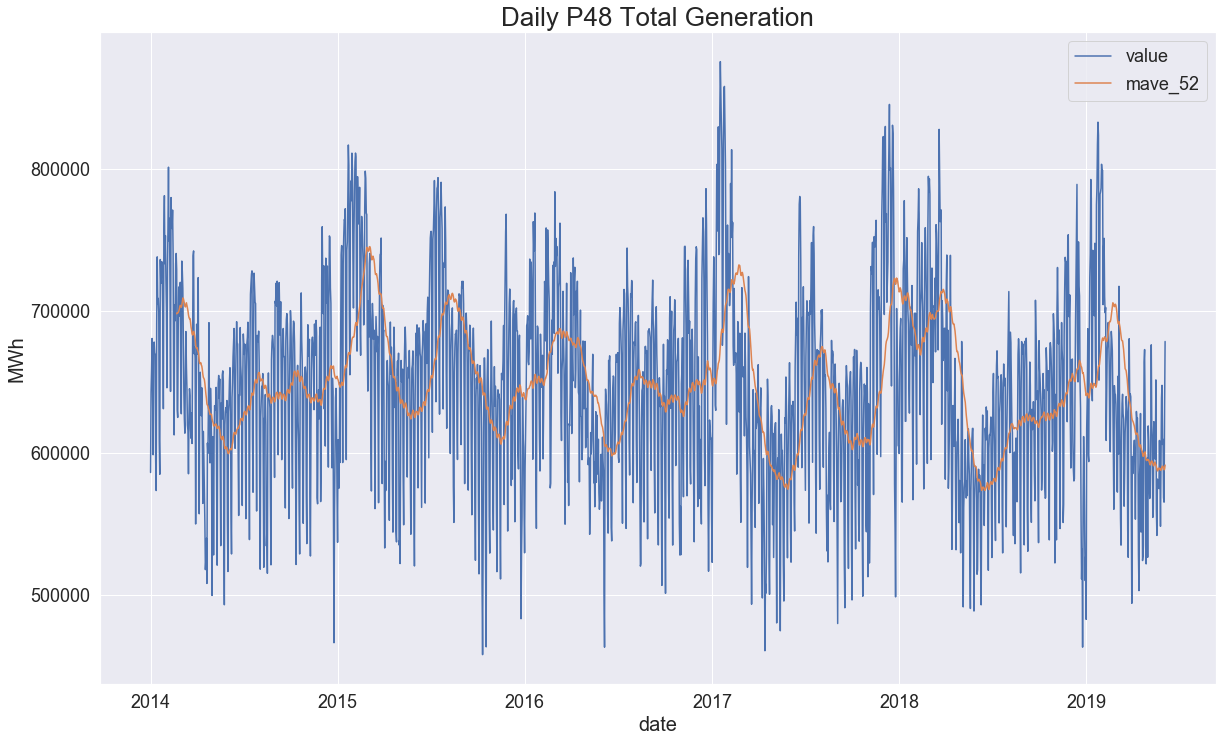

In [14]:
gen = data_14_19_df[
    data_14_19_df["indicador"]=="Generación programada PBF total"][["value"]]
gen["mave_52"] = gen["value"].rolling(52).mean()
gen.plot()
plt.title("Daily P48 Total Generation")
plt.ylabel("MWh")
plt.show()

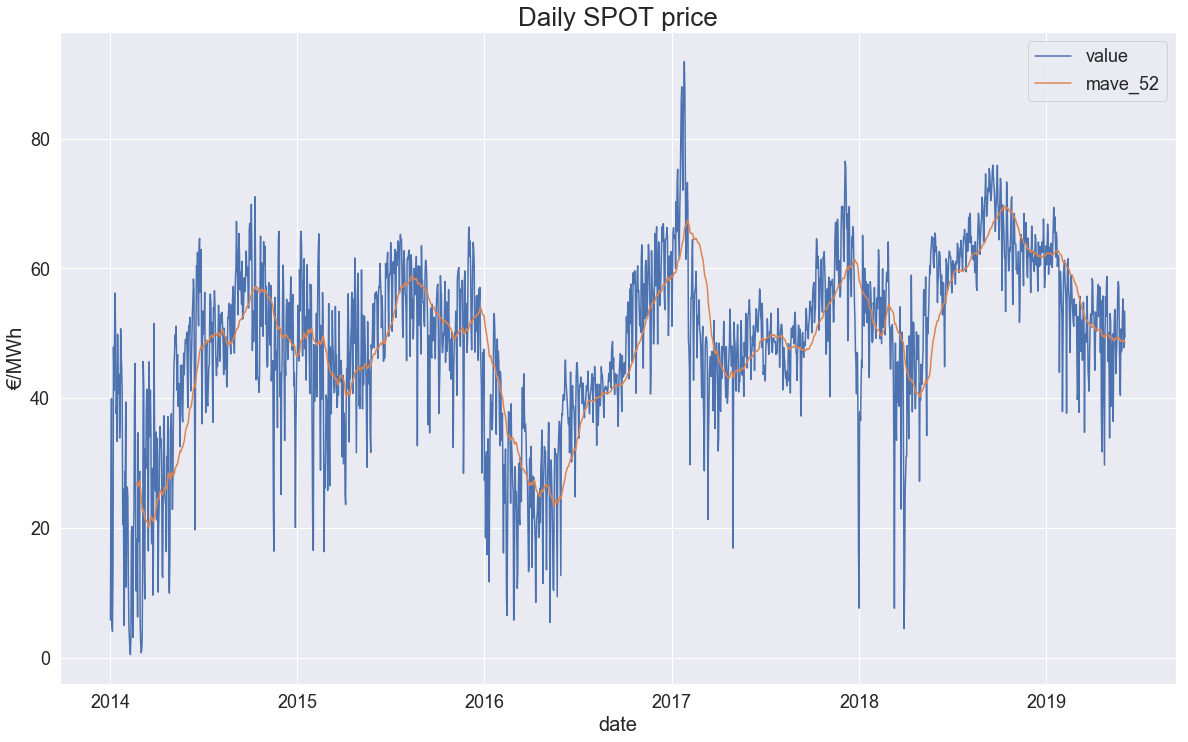

In [20]:
price = data_14_19_df[
    (data_14_19_df["indicador"]=="Precio mercado SPOT Diario") &
    (data_14_19_df["geo_id"]==3)][["value"]]
price["mave_52"] = price["value"].rolling(52).mean()
price.plot()

plt.title("Daily SPOT price")
plt.ylabel("€/MWh")
plt.show()


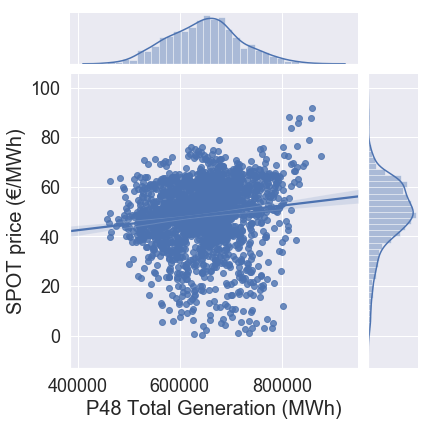

In [39]:
sns.jointplot(x=gen.values, y=price.values, kind="reg")
plt.xlabel("P48 Total Generation (MWh)")
plt.ylabel("SPOT price (€/MWh)")
plt.show()